<h1> Soft Actor Critic Demystified</h1>
<h4> By Vaishak Kumar </h4>
<br>
<a href="https://arxiv.org/pdf/1801.01290.pdf">Original Paper</a>
<br> 
<a href="https://github.com/higgsfield/RL-Adventure-2">Adapted from higgsfield's implementation</a>

In [1]:
import math
import random

import gym
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.distributions import Normal

from IPython.display import clear_output
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import display

%matplotlib inline

use_cuda = torch.cuda.is_available()
device   = torch.device("cuda" if use_cuda else "cpu")

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint

from gym import Env
from collections import OrderedDict

ics = dict(L=2480.,
           A=758.0,
           G=1125,
           T=5.053333333333333e-6,
           P=6e9,
           K=6e13,
           S=5e11
           )
pars = dict(Sigma=1.5 * 1e8,
            Cstar=5500,
            a0=0.03,
            aT=3.2 * 1e3,
            l0=26.4,
            lT=1.1 * 1e6,
            delta=0.01,
            m=1.5,
            g=0.02,
            p=0.04,
            Wp=2000,
            q0=20,
            b=5.4 * 1e-7,
            yE=147,
            eB=4 * 1e10,
            eF=4 * 1e10,
            i=0.25,
            wL=0,
            k0=0.1,
            aY=0.,
            aB=3e5,
            aF=5e6,
            aR=7e-18,
            sS=1. / 50.,
            sR=1.,
            ren_sub=.5,
            carbon_tax=.5,
            i_DG=0.1,
            L0=0,
            )


class DynEnv(Env):

    def __init__(self, params, initials, env_type=None, reward_type=None):

        # Get the environment type
        self.env_type = env_type
        self.env = self.get_env(env_type)

        # Initialise class variables
        self.dt = 1
        self.params = params
        self.initials = initials

        # We initialise the environment with a reset
        _ = self.reset()

        # Get the reward type
        self.reward_type = reward_type
        self.reward_function = self.get_reward_function(reward_type)

        # Planetary boundaries
        self.A_PB = 945  # TODO check these values
        self.W_PB = 1.84e4
        self.P_PB = 1e6
        self.PB_vec = np.array([self.A_PB, self.W_PB, self.P_PB])
        self.action_space = np.zeros(1)
        self.observation_space = np.zeros(7)

    def step(self, action=0) -> (np.array, float, bool):
        """The main step function where we call the others from"""

        next_t = self.t + self.dt

        # we adjust the parameters given the actions taken
        self.adjust_parameters(action)

        # we call the ode solver with the new parameters
        self.state = self.ode_solver(next_t)

        # Check if we have reached a final state
        if self.state_is_final():
            self.final_state = True

        reward = self.reward_function()
        self.t = next_t

        return self.state, reward, self.final_state

    def reset(self):
        """Resetting the environment at the start of an episode"""

        self.state = np.array(list(self.initials.values()))
        self.t = 0
        self.final_state = False
        
        return self.state
    
    def ode_solver(self, next_t) -> np.array:
        """This is where we solve the dynamical system of equations to get the next state"""

        # we use the scipy ode solver: odeint
        ode_solutions = odeint(func=self.dynamic_eqs,
                               y0=self.state,
                               t=[self.t, next_t],
                               mxstep=50000)

        # we take the values of the variables on the last time step as our next state
        return ode_solutions[-1, :]

    def dynamic_eqs(self, LAGTPKS, t) -> list:
        """The differential equations we have to solve for the next step"""

        # We define variables for simpler notation
        def phot(A, T):
            """Photosynthesis"""
            return (self.params['l0'] - self.params['lT'] * T) * np.sqrt(A / self.params['Sigma'])

        def resp(T):
            """Respiration"""
            return self.params['a0'] + self.params['aT'] * T

        def diff(L, A, G=0.):
            """Diffusion between atmosphere and ocean"""
            return self.params['delta'] * (self.params['Cstar'] - L - G - (1 + self.params['m']) * A)

        def fert(W):
            """Human fertility"""
            return 2 * self.params['p'] * self.params['Wp'] * W / (self.params['Wp'] ** 2 + W ** 2)

        def mort(W):
            """Human mortality"""
            return self.params['q0'] / W

        # We unpack the state variables and derived variables
        L, A, G, T, P, K, S = LAGTPKS
        B, F, R, Y, W = self.compute_derived_variables()

        # clamp here

        # odes to solve
        dL = (phot(A, T) - resp(T)) * L - B
        dA = -dL + diff(L, A, G)
        dG = -F
        dT = self.params['g'] * (A / self.params['Sigma'] - T)
        dP = P * (fert(W) - mort(W))
        dK = self.params['i'] * Y - self.params['k0'] * K
        dS = self.params['sR'] * R - self.params['sS'] * S

        return [dL, dA, dG, dT, dP, dK, dS]

    def compute_derived_variables(self) -> tuple:
        """Compute the variables that depend on the state variables"""

        # Unpack state variables
        L, A, G, T, P, K, S = self.state

        # Recurrent variables for simpler computation
        Xb = self.params['aB'] * L ** 2.
        Xf = self.params['aF'] * G ** 2.
        Xr = self.params['aR'] * S ** 2.
        X = Xb + Xf + Xr
        Z = (P * K) ** (2 / 5) / X ** (4 / 5)

        # derived variables
        B = Xb * Z / self.params['eB']
        F = Xf * Z / self.params['eF']
        R = Xr * Z
        Y = self.params['yE'] * (self.params['eB'] * B + self.params['eF'] * F + R)
        W = (1. - self.params['i']) * Y / P + self.params['wL'] * L / self.params['Sigma']

        return B, F, R, Y, W

    def adjust_parameters(self, action):
        """Adjust the parameters before computing the ODE by using the actions"""
        aR_default = 7e-18
        # TODO extend this to multiple dimensions
        self.params['aR'] = aR_default * (1 + action)

    def get_env(self, env_type):
        pass

    def get_reward_function(self, reward_type):
        """Choosing a reward function"""

        def planet_boundaries():
            _, A, _, _, P, _, _ = self.state
            _, _, _, _, W = self.compute_derived_variables()
            state_vec = np.array([A, W, P])
            r_t = np.linalg.norm(state_vec - self.PB_vec)
            if self.inside_planetary_boundaries():
                return r_t
            return 0

        return planet_boundaries

    def state_is_final(self) -> bool:
        """Check to see if we are in a terminal state"""

        # We use the short-circuiting functionality of Python for a compact if statement:
        # we end the episode early if we move outside planetary boundaries but not too early
        if self.t > 200 and (not self.inside_planetary_boundaries() or self.t > 600):
            return True
        return False

    def inside_planetary_boundaries(self) -> bool:
        """Check if we are inside the planetary boundaries"""
        _, A, _, _, P, _, _ = self.state
        _, _, _, _, W = self.compute_derived_variables()

        if A < self.A_PB and W > self.W_PB and P > self.P_PB:
            return True
        return False

<h2>Auxilliary Functions</h2>

In [3]:
class ReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0
    
    def push(self, state, action, reward, next_state, done):
        if len(self.buffer) < self.capacity:
            self.buffer.append(None)
        self.buffer[self.position] = (state, action, reward, next_state, done)
        self.position = (self.position + 1) % self.capacity
    
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        state, action, reward, next_state, done = map(np.stack, zip(*batch))
        return state, action, reward, next_state, done
    
    def __len__(self):
        return len(self.buffer)

In [4]:
class NormalizedActions(gym.ActionWrapper):
    def action(self, action):
        low  = self.action_space.low
        high = self.action_space.high
        
        action = low + (action + 1.0) * 0.5 * (high - low)
        action = np.clip(action, low, high)
        
        return action

    def _reverse_action(self, action):
        low  = self.action_space.low
        high = self.action_space.high
        
        action = 2 * (action - low) / (high - low) - 1
        action = np.clip(action, low, high)
        
        return actions

In [5]:
def plot(frame_idx, rewards):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, rewards[-1]))
    plt.plot(rewards)
    plt.show()

<h1>Network Definitions</h1>

In [6]:
class ValueNetwork(nn.Module):
    def __init__(self, state_dim, hidden_dim, init_w=3e-3):
        super(ValueNetwork, self).__init__()
        
        self.linear1 = nn.Linear(state_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, hidden_dim)
        self.linear3 = nn.Linear(hidden_dim, 1)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x
        
        
class SoftQNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-3):
        super(SoftQNetwork, self).__init__()
        
        self.linear1 = nn.Linear(num_inputs + num_actions, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        self.linear3 = nn.Linear(hidden_size, 1)
        
        self.linear3.weight.data.uniform_(-init_w, init_w)
        self.linear3.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state, action):
        x = torch.cat([state, action], 1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x)
        return x
        
        
class PolicyNetwork(nn.Module):
    def __init__(self, num_inputs, num_actions, hidden_size, init_w=3e-3, log_std_min=-20, log_std_max=2):
        super(PolicyNetwork, self).__init__()
        
        self.log_std_min = log_std_min
        self.log_std_max = log_std_max
        
        self.linear1 = nn.Linear(num_inputs, hidden_size)
        self.linear2 = nn.Linear(hidden_size, hidden_size)
        
        self.mean_linear = nn.Linear(hidden_size, num_actions)
        self.mean_linear.weight.data.uniform_(-init_w, init_w)
        self.mean_linear.bias.data.uniform_(-init_w, init_w)
        
        self.log_std_linear = nn.Linear(hidden_size, num_actions)
        self.log_std_linear.weight.data.uniform_(-init_w, init_w)
        self.log_std_linear.bias.data.uniform_(-init_w, init_w)
        
    def forward(self, state):
        x = F.relu(self.linear1(state))
        x = F.relu(self.linear2(x))
        
        mean    = self.mean_linear(x)
        log_std = self.log_std_linear(x)
        log_std = torch.clamp(log_std, self.log_std_min, self.log_std_max)
        
        return mean, log_std
    
    def evaluate(self, state, epsilon=1e-6):
        mean, log_std = self.forward(state)
        std = log_std.exp()
        
        normal = Normal(0, 1)
        z      = normal.sample()
        action = torch.tanh(mean+ std*z.to(device))
        log_prob = Normal(mean, std).log_prob(mean+ std*z.to(device)) - torch.log(1 - action.pow(2) + epsilon)
        return action, log_prob, z, mean, log_std
        
    
    def get_action(self, state):
        state = torch.FloatTensor(state).unsqueeze(0).to(device)
        mean, log_std = self.forward(state)
        std = log_std.exp()
        
        normal = Normal(0, 1)
        z      = normal.sample().to(device)
        action = torch.tanh(mean + std*z)
        
        action  = action.cpu()#.detach().cpu().numpy()
        return action[0]

<h1> Update Function </h1>

In [7]:
def update(batch_size,gamma=0.99,soft_tau=1e-2,):
    
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    state      = torch.FloatTensor(state).to(device)
    next_state = torch.FloatTensor(next_state).to(device)
    action     = torch.FloatTensor(action).to(device)
    reward     = torch.FloatTensor(reward).unsqueeze(1).to(device)
    done       = torch.FloatTensor(np.float32(done)).unsqueeze(1).to(device)

    predicted_q_value1 = soft_q_net1(state, action)
    predicted_q_value2 = soft_q_net2(state, action)
    predicted_value    = value_net(state)
    new_action, log_prob, epsilon, mean, log_std = policy_net.evaluate(state)

    
    
# Training Q Function
    target_value = target_value_net(next_state)
    target_q_value = reward + (1 - done) * gamma * target_value
    q_value_loss1 = soft_q_criterion1(predicted_q_value1, target_q_value.detach())
    q_value_loss2 = soft_q_criterion2(predicted_q_value2, target_q_value.detach())


    soft_q_optimizer1.zero_grad()
    q_value_loss1.backward()
    soft_q_optimizer1.step()
    soft_q_optimizer2.zero_grad()
    q_value_loss2.backward()
    soft_q_optimizer2.step()    
# Training Value Function
    predicted_new_q_value = torch.min(soft_q_net1(state, new_action),soft_q_net2(state, new_action))
    target_value_func = predicted_new_q_value - log_prob
    value_loss = value_criterion(predicted_value, target_value_func.detach())

    
    value_optimizer.zero_grad()
    value_loss.backward()
    value_optimizer.step()
# Training Policy Function
    policy_loss = (log_prob - predicted_new_q_value).mean()

    policy_optimizer.zero_grad()
    policy_loss.backward()
    policy_optimizer.step()
    
    
    for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
        target_param.data.copy_(
            target_param.data * (1.0 - soft_tau) + param.data * soft_tau
        )

<h2> Initializations </h2>

In [8]:
env =  env = gym.make("Pendulum-v0")
env = gym.make('MountainCarContinuous-v0')

action_dim = env.action_space.shape[0]
state_dim  = env.observation_space.shape[0]
hidden_dim = 256

value_net        = ValueNetwork(state_dim, hidden_dim).to(device)
target_value_net = ValueNetwork(state_dim, hidden_dim).to(device)

soft_q_net1 = SoftQNetwork(state_dim, action_dim, hidden_dim).to(device)
soft_q_net2 = SoftQNetwork(state_dim, action_dim, hidden_dim).to(device)
policy_net = PolicyNetwork(state_dim, action_dim, hidden_dim).to(device)

for target_param, param in zip(target_value_net.parameters(), value_net.parameters()):
    target_param.data.copy_(param.data)
    

value_criterion  = nn.MSELoss()
soft_q_criterion1 = nn.MSELoss()
soft_q_criterion2 = nn.MSELoss()

value_lr  = 3e-4
soft_q_lr = 3e-4
policy_lr = 3e-4

value_optimizer  = optim.Adam(value_net.parameters(), lr=value_lr)
soft_q_optimizer1 = optim.Adam(soft_q_net1.parameters(), lr=soft_q_lr)
soft_q_optimizer2 = optim.Adam(soft_q_net2.parameters(), lr=soft_q_lr)
policy_optimizer = optim.Adam(policy_net.parameters(), lr=policy_lr)


replay_buffer_size = 1000000
replay_buffer = ReplayBuffer(replay_buffer_size)

# Training Hyperparameters

In [9]:
max_frames  = 80000#40000
max_steps   = 500
frame_idx   = 0
rewards     = []
batch_size  = 128

# Training Loop

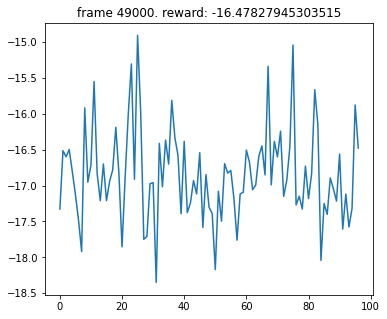

In [ ]:
while frame_idx < max_frames:
    state = env.reset()
    episode_reward = 0
    
    for step in range(max_steps):
        if frame_idx >1000:
            action = policy_net.get_action(state).detach()
            next_state, reward, done, _ = env.step(action.numpy())
        else:
            action = env.action_space.sample()
            next_state, reward, done, _ = env.step(action)
        
        
        replay_buffer.push(state, action, reward, next_state, done)
        
        state = next_state
        episode_reward += reward
        frame_idx += 1
        
        if len(replay_buffer) > batch_size:
            update(batch_size)
        
        if frame_idx % 1000 == 0:
            plot(frame_idx, rewards)
        
        if done:
            break
        
    rewards.append(episode_reward)

<h2> Visualize Trained Algorithm </h2> - <a href="http://mckinziebrandon.me/TensorflowNotebooks/2016/12/21/openai.html">source</a>  

In [ ]:
def display_frames_as_gif(frames):
    """
    Displays a list of frames as a gif, with controls
    """
    #plt.figure(figsize=(frames[0].shape[1] / 72.0, frames[0].shape[0] / 72.0), dpi = 72)
    patch = plt.imshow(frames[0])
    plt.axis('off')

    def animate(i):
        patch.set_data(frames[i])

    anim = animation.FuncAnimation(plt.gcf(), animate, frames = len(frames), interval=50)
    display(anim)

In [ ]:
env = gym.make('MountainCar-v0')

# # Run a demo of the environment
# state = env.reset()
# cum_reward = 0
# frames = []
# for t in range(50000):
#     # Render into buffer. 
#     frames.append(env.render(mode = 'rgb_array'))
#     action = policy_net.get_action(state)
#     state, reward, done, info = env.step(action.detach())
#     if done:
#         break
# env.close()
# display_frames_as_gif(frames)
#action_dim = env.action_space.shape[0]

